In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Step 1: Define paths and configurations
data_dir = r"C:\Users\HP\OneDrive\Face mask Classifier\Compressed\Dataset"  # Ensure the directory structure has subfolders: 'without_mask', 'with_mask', 'improperly_worn_mask' under 'train' and 'test'.
batch_size = 32
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Step 2: Data Preprocessing and Augmentation
transform_train = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(224),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [5]:
# Step 3: Load Data
dataset = datasets.ImageFolder(
    data_dir, 
    transform=transform_train if "train" in data_dir else transform_test
)

# Split the dataset into train and test manually (70% train, 30% test)
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
dataset_train, dataset_test = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

# Ensure dataset classes are correct
print("Classes:", dataset.classes)  # Should output: ['without_mask', 'with_mask', 'improperly_worn_mask']


Classes: ['mask_weared_incorrect', 'with_mask', 'without_mask']


In [6]:
# Step 4: Model Selection (Using ResNet)
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 3)  # Ensure labels correspond to: 'without_mask', 'with_mask', 'improperly_worn_mask'.
model = model.to(device)


D:\anaconda\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
D:\anaconda\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\HP\AppData\Roaming\SPB_16.6/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100.0%


In [7]:
# Step 5: Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
# Step 6: Training Function
def train_model(model, criterion, optimizer, train_loader, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

    return model



In [21]:
# Step 7: Evaluation Function
def evaluate_model(model, test_loader):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=dataset.classes))
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm)


In [19]:
dataset.classes

['mask_weared_incorrect', 'with_mask', 'without_mask']

In [12]:

# Step 8: Train and Evaluate
model = train_model(model, criterion, optimizer, train_loader, num_epochs)
evaluate_model(model, test_loader)



Epoch 1/20, Loss: 0.0716
Epoch 2/20, Loss: 0.0656
Epoch 3/20, Loss: 0.0533
Epoch 4/20, Loss: 0.0405
Epoch 5/20, Loss: 0.0193
Epoch 6/20, Loss: 0.0612
Epoch 7/20, Loss: 0.0270
Epoch 8/20, Loss: 0.0131
Epoch 9/20, Loss: 0.0270
Epoch 10/20, Loss: 0.0265
Epoch 11/20, Loss: 0.0175
Epoch 12/20, Loss: 0.0181
Epoch 13/20, Loss: 0.0095
Epoch 14/20, Loss: 0.0209
Epoch 15/20, Loss: 0.0030
Epoch 16/20, Loss: 0.0090
Epoch 17/20, Loss: 0.0433
Epoch 18/20, Loss: 0.0128
Epoch 19/20, Loss: 0.0078


KeyboardInterrupt: 

In [22]:
evaluate_model(model, test_loader)

Classification Report:
                       precision    recall  f1-score   support

mask_weared_incorrect       0.99      1.00      1.00       896
            with_mask       0.99      0.99      0.99       917
         without_mask       1.00      0.99      0.99       882

             accuracy                           0.99      2695
            macro avg       0.99      0.99      0.99      2695
         weighted avg       0.99      0.99      0.99      2695

Confusion Matrix:
 [[896   0   0]
 [  6 907   4]
 [  2   6 874]]


In [23]:
# Step 9: Save Model
torch.save(model.state_dict(), r"C:\Users\HP\OneDrive\Face mask Classifier\Compressed\chk\face_mask_classifier.pth")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


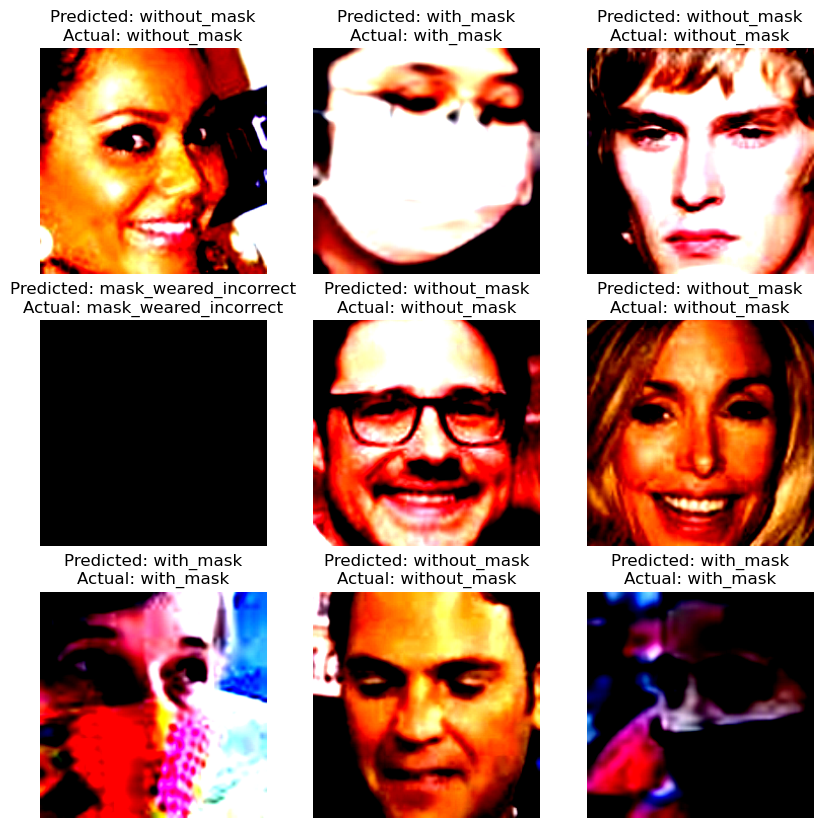

In [17]:

# Step 10: Visualize Some Predictions
def visualize_predictions(model, test_loader):
    model.eval()
    inputs, labels = next(iter(test_loader))
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)

    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(np.transpose(inputs[i].cpu().numpy(), (1, 2, 0)))
        plt.title(f"Predicted: {dataset.classes[preds[i]]}\nActual: {dataset.classes[labels[i]]}")
        plt.axis("off")
    plt.show()

visualize_predictions(model, test_loader)
